# T5

### Вступление

**T5** (расшифровывается как Text-to-Text Transfer Transformer) - это семейство мощных моделей на базе Transformer, разработанное Google Research и представленное в 2019-2020 годах.

Авторы предложили унифицированный подход: любую задачу обработки естественного языка можно свести к преобразованию одной строки текста в другую строку текста. Благодаря такому подходу одна и та же модель, одна функция потерь, одни гиперпараметры могут решать десятки разных задач.

Архитектура: Encoder-Decoder Transformer (в отличие от BERT - только encoder, GPT - только decoder)

**RuT5** - это семейство русскоязычных моделей на архитектуре T5 (Text-to-Text Transfer Transformer), разработанных специально для русского языка.
Это одна из самых популярных и качественных seq2seq-моделей (encoder-decoder) для русского языка в 2021-2025 годах.

Обучение модели (fine-tune) RuT5 на примере https://github.com/RussianNLP/RuCoLA/blob/main/baselines/finetune_t5.py.

Модель ruT5 дообучается для задачи классификации грамматической приемлемости предложений (RuCoLA).

**Специфика**
BERT - классификатор, T5 - генератор текста.

Мы преобразуем задачу в:

```
Вход: предложение
Выход: Да / Нет
```

### Подготовка

In [34]:
# preload local libs
import sys
import os
import pathlib
import numpy as np

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [17]:
import pandas as pd
# import numpy as np
# import seaborn as sns
import torch
import matplotlib.pyplot as plt
from tqdm.auto import trange

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

# from transformers import BertTokenizer, AutoModel, AutoTokenizer, AutoModelForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader

from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
)

# from lib import utils

import warnings
warnings.filterwarnings("ignore")

In [18]:
DEVICE = 'cuda:0'

#### Imports

In [19]:
T5_MODEL_NAME = "ai-forever/ruT5-base"
# T5_MODEL_NAME = "ai-forever/ruT5-large"

N_EPOCHS = 20
LR_VALUE = 5e-4
DECAY_VALUE = 1e-4
BATCH_SIZE = 16

In [20]:
train_df = pd.read_csv(project_dir + "/hw-08/RuCoLA/data/in_domain_train.csv")
test_df  = pd.read_csv(project_dir + "/hw-08/RuCoLA/data/in_domain_dev.csv")

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=1,
    stratify=train_df['acceptable']
)

# Так как дальше в Dataloader работаем с индексами строк, то после стратификации нужно пересобрать индексы
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

#### Модель и токенизатор

In [ ]:
t5_tokenizer = T5Tokenizer.from_pretrained(T5_MODEL_NAME)

t5_model = T5ForConditionalGeneration.from_pretrained(T5_MODEL_NAME)
t5_model.to(DEVICE)

#### Optimizer

In [22]:
from torch import optim

# model.classifier.parameters()
# criterion = nn.CrossEntropyLoss()

t5_optimizer = optim.AdamW(
    t5_model.parameters(),
    lr=LR_VALUE,
    weight_decay=DECAY_VALUE
)

#### Dataset и Dataloader

In [23]:
def t5_encoding_func(text, max_length=128):
    return t5_tokenizer(
        text,
        truncation=True,            # что делать, если текст длиннее. Если текст длиннее max_length, то обрезать его (по умолчанию с конца)
        padding="max_length",       # как выравнивать длину. Дополнять (паддить) все примеры в батче до длины max_length нулями (padding token)
        max_length=max_length,      # максимальная длина последовательности после токенизации (включая специальные токены)
        return_tensors="pt",        # в каком формате вернуть результат. Вернуть результат в формате PyTorch тензоров ("tf" - TensorFlow, "np" - numpy)
        add_special_tokens=True,    # добавлять [CLS], [SEP] и т.д.?
        return_attention_mask=True, # нужно ли возвращать attention mask. Добавить в результат словарь ключ attention_mask (1 = реальный токен, 0 = padding)
    )

In [24]:
class T5RuCoLADataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['sentence'].tolist()
        self.labels = df['acceptable'].tolist()
        # self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = t5_encoding_func(self.texts[idx])

        # В отличии от BERT тут нельзя бинарные метки передать модели, из них нужно сделать словесное представление
        # 0 -> нет, 1 -> да
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        label_text = 'да' if self.labels[idx] == 1 else 'нет'
        label_ids = t5_encoding_func(label_text)['input_ids'].squeeze(0)
        
        # При использовании коллатора значение меток придется вложить в item
        item['labels'] = label_ids

        return item

In [25]:
train_dataset = T5RuCoLADataset(train_df, t5_tokenizer)
val_dataset   = T5RuCoLADataset(val_df, t5_tokenizer)
test_dataset  = T5RuCoLADataset(test_df, t5_tokenizer)

# DataCollator делает dynamic padding, shift decoder tokens, заменяет padding на -100
# Последнее особенно важно — иначе loss считается по PAD токенам.
# Автоматическое выравнивание: При использовании pad_to_multiple_of=5 все пакеты будут дополнены так, чтобы их длина была кратна 5.
# Если максимальная длина в пакете = 17, дополнение будет до 20 (ближайшее число, кратное 5)
# Зачем это нужно?
#   * Многие GPU работают эффективнее с тензорами, размеры которых кратны определенным числам (8, 16, 32, 64, 128)
#   * CUDA ядра часто оптимизированы для размеров, кратных степеням двойки
# Для современных GPU (NVIDIA)
#   pad_to_multiple_of=8    # Наиболее распространенное
#   pad_to_multiple_of=16   # Для больших пакетов
#   pad_to_multiple_of=32   # Для максимальной производительности
# Для конкретных случаев
#   pad_to_multiple_of=64   # При использовании mixed precision
#   pad_to_multiple_of=128  # Для очень больших моделей
# Не влияет на качество модели
# Влияет только на скорость обучения и использование памяти
data_collator = DataCollatorForSeq2Seq(t5_tokenizer, pad_to_multiple_of=8)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=data_collator)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)

# next(iter(train_loader))

#### Train Loop

In [26]:
# Цикл обучения

def t5_train_epoch(model, optimizer, loader):
    model.train()

    total_loss = 0
    total_tokens = 0

    for inputs in loader:
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        # Удивительное дело, но T5ForConditionalGeneration умеет сразу на вход принимать labels и 
        # использует CrossEntropyLoss для оценки. Поэтому выделять метки специяоно не требуется
        outputs = model(**inputs)
        # loss = criterion(outputs.logits, labels)
        # получим LOSS
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()

        # это функция для ограничения нормы градиентов (gradient clipping), 
        # которая предотвращает проблему "взрыва градиентов" (exploding gradients) при обучении нейронных сетей.
        # Она вычисляет общую норму градиентов и масштабирует градиенты, если норма превышает порог
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0, norm_type=2)
        
        optimizer.step()

        # Просто сума ошибки деленная на размер батча - это не самый корректный способ подсчета величины ошибки
        # Если batch sizes или длины последовательностей отличаются - итоговый epoch loss будет слегка смещён.
        # поэтому так:
        tokens = (inputs["labels"] != -100).sum()
        total_loss += loss.item() * tokens.item()
        total_tokens += tokens.item()

    return total_loss / total_tokens


In [27]:
# Валидация

def t5_eval_epoch(model, loader):
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}

            # Генерация предсказаний
            generated_ids = model.generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=2
            )

            # Декодируем предсказания
            preds = t5_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Декодируем labels
            labels = t5_tokenizer.batch_decode(
                batch["labels"].masked_fill(batch["labels"] == -100, t5_tokenizer.pad_token_id),
                skip_special_tokens=True
            )

            all_preds.extend(preds)
            all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    mcc = matthews_corrcoef(all_labels, all_preds)

    return acc, f1, mcc


In [ ]:
start_epoch = 0
opt_losses = []
opt_metrics = []

TMP_PATH = 'T5_model.tmp.pth'
SAVE_FILE = 'T5_model.pth'

# Проверяем, есть ли чекпойнт
if os.path.exists(SAVE_FILE):
    checkpoint = torch.load(SAVE_FILE, map_location=DEVICE)
    
    t5_model.load_state_dict(checkpoint['model_state_dict'])
    t5_optimizer.load_state_dict(checkpoint['opt_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    opt_losses = checkpoint['losses']
    opt_metrics = checkpoint['metrics']
    
    print(f"Продолжаем обучение с эпохи {start_epoch}")


for epoch in trange(start_epoch, N_EPOCHS):
    train_loss = t5_train_epoch(t5_model, t5_optimizer, train_loader)
    opt_losses.append(train_loss)

    val_acc, val_f1, val_mcc = t5_eval_epoch(t5_model, val_loader)
    opt_metrics.append({'acc': val_acc, 'f1': val_f1, 'mcc': val_mcc})

    print(f"TL={train_loss}, F1={val_f1}, MCC={val_mcc}")

    torch.save(
        {
            'model_state_dict': t5_model.state_dict(),
            'opt_state_dict': t5_optimizer.state_dict(),
            'epoch': epoch,
            'epochs': N_EPOCHS,
            'losses': opt_losses,
            'metrics': opt_metrics
        },
        TMP_PATH
        )
    
    if os.path.exists(SAVE_FILE):
        os.remove(SAVE_FILE)
    os.rename(TMP_PATH, SAVE_FILE)

### Визуализация

In [29]:
# извлечение метрик по эпохам
pth = torch.load(
    SAVE_FILE,
    map_location=torch.device("cpu"),      # иначе она забивает видеапамять
    weights_only=True,
    )

pth_losses = pth['losses']
pth_metrics = pth['metrics']
pth_f1 = []
pth_mcc = []

for a, b in enumerate(pth_losses):
    epoch = a+1
    loss = b
    pth_f1.append(pth_metrics[a]['f1'])
    pth_mcc.append(pth_metrics[a]['mcc'])
    


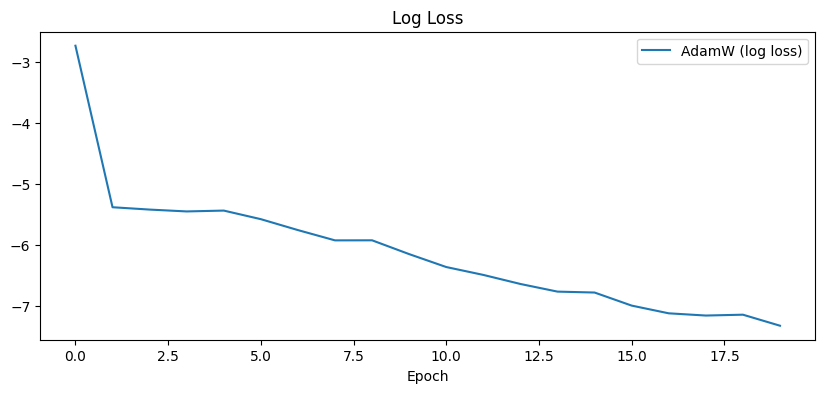

In [36]:
plt.figure(figsize=(10, 4))

plt.plot(range(len(pth_losses)), np.log(pth_losses), label='AdamW (log loss)')

plt.title('Log Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

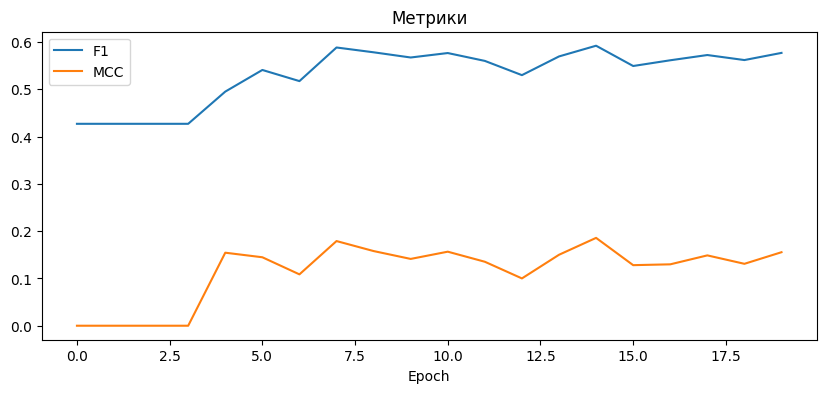

In [37]:
plt.figure(figsize=(10, 4))

plt.plot(range(len(pth_f1)), pth_f1, label='F1')
plt.plot(range(len(pth_mcc)), pth_mcc, label='MCC')

plt.title('Метрики')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Тестирование

In [32]:
# извлечение метрик по эпохам
pth_model = torch.load(SAVE_FILE, map_location=torch.device(DEVICE))

t5_model.load_state_dict(pth_model['model_state_dict'])

val_acc, val_f1, val_mcc = t5_eval_epoch(t5_model, test_loader)

print("Test Accuracy:", val_acc)
print("Test MCC:", val_mcc)
print("Test F1:", val_f1)

Test Accuracy: 0.6795523906408952
Test MCC: 0.15178100585146448
Test F1: 0.5758827984927948


### Выводы

После первой эпохи T5 модель потеряла интерес к обучению, что и видно ма графиках и метриках. Угадывание результата почти случайно.

## Заметка на будущее

Данную задача была решена классическим pytorch. 

Однако, есть возможность использовать готовые инструменты HF для обучения: Seq2SeqTrainingArguments, Seq2SeqTrainer